# DQAN (Deep Q-Adverserial Nets): DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [4]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [5]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [6]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.03991097 -0.17170907  0.01916614  0.26227969] 0 1.0 False {}
state, action, reward, done, info
[ 0.03647679  0.02313413  0.02441174 -0.02429693] 1 1.0 False {}
state, action, reward, done, info
[ 0.03693948  0.21789764  0.0239258  -0.30917882] 1 1.0 False {}
state, action, reward, done, info
[ 0.04129743  0.02244311  0.01774222 -0.00904741] 0 1.0 False {}
state, action, reward, done, info
[ 0.04174629  0.21730618  0.01756127 -0.29608007] 1 1.0 False {}
state, action, reward, done, info
[ 0.04609241  0.41217343  0.01163967 -0.58317313] 1 1.0 False {}
state, action, reward, done, info
[ 5.43358824e-02  6.07130396e-01 -2.37904973e-05 -8.72166786e-01] 1 1.0 False {}
state, action, reward, done, info
[ 0.06647849  0.80225267 -0.01746713 -1.16485719] 1 1.0 False {}
state, action, reward, done, info
[ 0.08252354  0.99759759 -0.04076427 -1.46296495] 1 1.0 False {}
state, action, reward, done, info
[ 0.1024755   1.19319465 -0.07002357 -1.76809818] 1 1.0 Fal

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1931946516072018 -1.7680981776938154


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    # States or observations as input
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Actions as output
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [9]:
# tf.layers.dense(
#     inputs, ????????????????????????
#     units, ??????????????????????
#     activation=None,
#     use_bias=True, OOOOOOOOOOOOOOOOOOOOOOOK
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), OOOOOOOOOOOOOOOK
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ??????????????????
#     name=None,
#     reuse=None
# )

In [10]:
# Q function
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training) #training=True ~ batchnorm
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training) #training=True ~ batchnorm
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits_actions)

        return logits

In [11]:
# This is a reward function: Rt(at) or Rt(~at)
def discriminator(actions, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [12]:
# Qt(St, At) = Rt(St+1, At) + max(alpha*Qt+1(St+1))
def model_loss(states, actions, action_size, hidden_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real current input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, reuse=False)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake, rewards_real

In [13]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [14]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake, self.rewards_real = model_loss(
            action_size=action_size, actions=self.actions, states=self.states, hidden_size=hidden_size, 
            targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [15]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [18]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [19]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [20]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Current reward required for the Q-learning/ targetQs
            feed_dict = {model.states: states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))

            # Next action required for the Q-learning/ targetQs
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 6.0 Average reward fake: 0.49704456329345703 Average reward real: 0.49869999289512634 Training d_loss: 1.3882 Training g_loss: 0.7117 Training q_loss: 0.3859 Explore P: 0.9994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 17.0 Average reward fake: 0.4888542592525482 Average reward real: 0.5279325246810913 Training d_loss: 1.3116 Training g_loss: 0.7209 Training q_loss: 1.0748 Explore P: 0.9977
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 12.0 Average reward fake: 0.46334296464920044 Average reward real: 0.5546914935112 Training d_loss: 1.2139 Training g_loss: 0.7805 Training q_loss: 1.7377 Explore P: 0.9965
-

-------------------------------------------------------------------------------
Episode: 23 Total reward: 8.0 Average reward fake: 0.4027729034423828 Average reward real: 0.5447486042976379 Training d_loss: 1.1520 Training g_loss: 1.0035 Training q_loss: 435.5079 Explore P: 0.9571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 12.0 Average reward fake: 0.2783053517341614 Average reward real: 0.6714995503425598 Training d_loss: 0.8109 Training g_loss: 1.3905 Training q_loss: 6475.7026 Explore P: 0.9560
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 39.0 Average reward fake: 0.4339321255683899 Average reward real: 0.6314984560012817 Training d_loss: 1.0853 Training g_loss: 0.8822 Training q_loss: 3132.1616 Explore 

-------------------------------------------------------------------------------
Episode: 46 Total reward: 25.0 Average reward fake: 0.30361467599868774 Average reward real: 0.6499476432800293 Training d_loss: 0.9597 Training g_loss: 1.2008 Training q_loss: 371.2197 Explore P: 0.9152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 14.0 Average reward fake: 0.4266943037509918 Average reward real: 0.7687488794326782 Training d_loss: 0.8989 Training g_loss: 0.8592 Training q_loss: 469.1011 Explore P: 0.9140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 11.0 Average reward fake: 0.29569342732429504 Average reward real: 0.5059589147567749 Training d_loss: 1.2045 Training g_loss: 1.2526 Training q_loss: 458.5504 Explore

-------------------------------------------------------------------------------
Episode: 69 Total reward: 12.0 Average reward fake: 0.32946377992630005 Average reward real: 0.731096088886261 Training d_loss: 0.8445 Training g_loss: 1.1050 Training q_loss: 20.0177 Explore P: 0.8790
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 38.0 Average reward fake: 0.3551863729953766 Average reward real: 0.54832524061203 Training d_loss: 1.1637 Training g_loss: 1.0079 Training q_loss: 13.8545 Explore P: 0.8757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 47.0 Average reward fake: 0.37829092144966125 Average reward real: 0.6266161799430847 Training d_loss: 1.0589 Training g_loss: 0.9745 Training q_loss: 38.5105 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 92 Total reward: 13.0 Average reward fake: 0.3241623342037201 Average reward real: 0.5274467468261719 Training d_loss: 1.1784 Training g_loss: 1.1253 Training q_loss: 871.3182 Explore P: 0.8324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 17.0 Average reward fake: 0.3569019138813019 Average reward real: 0.5497741103172302 Training d_loss: 1.1626 Training g_loss: 1.0174 Training q_loss: 1511.0616 Explore P: 0.8310
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 14.0 Average reward fake: 0.3117060661315918 Average reward real: 0.6556049585342407 Training d_loss: 0.9566 Training g_loss: 1.1834 Training q_loss: 1176.3633 Explore

-------------------------------------------------------------------------------
Episode: 116 Total reward: 25.0 Average reward fake: 0.37557217478752136 Average reward real: 0.8124861717224121 Training d_loss: 0.7649 Training g_loss: 0.9876 Training q_loss: 353.0877 Explore P: 0.7941
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 11.0 Average reward fake: 0.3274306654930115 Average reward real: 0.7308353185653687 Training d_loss: 0.8433 Training g_loss: 1.1291 Training q_loss: 91.6396 Explore P: 0.7932
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 10.0 Average reward fake: 0.30652254819869995 Average reward real: 0.44544482231140137 Training d_loss: 1.3111 Training g_loss: 1.1797 Training q_loss: 73.5866 Explo

-------------------------------------------------------------------------------
Episode: 139 Total reward: 11.0 Average reward fake: 0.3775302767753601 Average reward real: 0.7511180639266968 Training d_loss: 0.8632 Training g_loss: 0.9910 Training q_loss: 425.4017 Explore P: 0.7595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 16.0 Average reward fake: 0.3469116687774658 Average reward real: 0.4775935709476471 Training d_loss: 1.2727 Training g_loss: 1.0597 Training q_loss: 582.4767 Explore P: 0.7583
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 11.0 Average reward fake: 0.34900909662246704 Average reward real: 0.47927990555763245 Training d_loss: 1.2711 Training g_loss: 1.0477 Training q_loss: 24.4415 Explo

-------------------------------------------------------------------------------
Episode: 162 Total reward: 21.0 Average reward fake: 0.3813626170158386 Average reward real: 0.8144304156303406 Training d_loss: 0.7692 Training g_loss: 0.9712 Training q_loss: 144.4397 Explore P: 0.7274
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 18.0 Average reward fake: 0.34604963660240173 Average reward real: 0.6077658534049988 Training d_loss: 1.0609 Training g_loss: 1.0694 Training q_loss: 431.1957 Explore P: 0.7261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 16.0 Average reward fake: 0.37085625529289246 Average reward real: 0.6225119233131409 Training d_loss: 1.0585 Training g_loss: 0.9777 Training q_loss: 103.6047 Expl

-------------------------------------------------------------------------------
Episode: 185 Total reward: 19.0 Average reward fake: 0.36010950803756714 Average reward real: 0.5521040558815002 Training d_loss: 1.1613 Training g_loss: 1.0287 Training q_loss: 48.5161 Explore P: 0.7000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 39.0 Average reward fake: 0.3851237893104553 Average reward real: 0.6926616430282593 Training d_loss: 0.9631 Training g_loss: 0.9640 Training q_loss: 61.5796 Explore P: 0.6973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 187 Total reward: 23.0 Average reward fake: 0.3415891230106354 Average reward real: 0.6708713173866272 Training d_loss: 0.9547 Training g_loss: 1.0728 Training q_loss: 44.6982 Explore 

-------------------------------------------------------------------------------
Episode: 208 Total reward: 20.0 Average reward fake: 0.36968010663986206 Average reward real: 0.6219800710678101 Training d_loss: 1.0581 Training g_loss: 1.0084 Training q_loss: 49.6097 Explore P: 0.6755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 25.0 Average reward fake: 0.35422223806381226 Average reward real: 0.8062552213668823 Training d_loss: 0.7486 Training g_loss: 1.0298 Training q_loss: 253.5580 Explore P: 0.6738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 11.0 Average reward fake: 0.3729771375656128 Average reward real: 0.686691164970398 Training d_loss: 0.9593 Training g_loss: 0.9836 Training q_loss: 164.9273 Explor

-------------------------------------------------------------------------------
Episode: 231 Total reward: 9.0 Average reward fake: 0.3950158655643463 Average reward real: 0.637107789516449 Training d_loss: 1.0596 Training g_loss: 0.9288 Training q_loss: 315.6867 Explore P: 0.6528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 40.0 Average reward fake: 0.3494010865688324 Average reward real: 0.6748130917549133 Training d_loss: 0.9552 Training g_loss: 1.0500 Training q_loss: 63.5060 Explore P: 0.6502
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 14.0 Average reward fake: 0.31885308027267456 Average reward real: 0.5914528965950012 Training d_loss: 1.0693 Training g_loss: 1.1375 Training q_loss: 56.4400 Explore P

-------------------------------------------------------------------------------
Episode: 254 Total reward: 20.0 Average reward fake: 0.3499378263950348 Average reward real: 0.6102396249771118 Training d_loss: 1.0599 Training g_loss: 1.0507 Training q_loss: 88.3892 Explore P: 0.6264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 20.0 Average reward fake: 0.38294321298599243 Average reward real: 0.6297882199287415 Training d_loss: 1.0586 Training g_loss: 0.9526 Training q_loss: 85.8309 Explore P: 0.6252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 12.0 Average reward fake: 0.3582395613193512 Average reward real: 0.5510454177856445 Training d_loss: 1.1613 Training g_loss: 1.0361 Training q_loss: 110.0267 Explore

-------------------------------------------------------------------------------
Episode: 277 Total reward: 44.0 Average reward fake: 0.3913939297199249 Average reward real: 0.6350248456001282 Training d_loss: 1.0589 Training g_loss: 0.9486 Training q_loss: 71.8010 Explore P: 0.6047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 9.0 Average reward fake: 0.36064115166664124 Average reward real: 0.6803964376449585 Training d_loss: 0.9570 Training g_loss: 1.0225 Training q_loss: 459.1029 Explore P: 0.6041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 24.0 Average reward fake: 0.38334137201309204 Average reward real: 0.506687343120575 Training d_loss: 1.2505 Training g_loss: 0.9594 Training q_loss: 71.2473 Explore 

-------------------------------------------------------------------------------
Episode: 300 Total reward: 22.0 Average reward fake: 0.5237148404121399 Average reward real: 0.6599551439285278 Training d_loss: 1.5477 Training g_loss: 0.7720 Training q_loss: 154.8318 Explore P: 0.5834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 10.0 Average reward fake: 0.6410356760025024 Average reward real: 0.4346333146095276 Training d_loss: 1.9005 Training g_loss: 0.4803 Training q_loss: 1121.8812 Explore P: 0.5828
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 22.0 Average reward fake: 0.45186036825180054 Average reward real: 0.49791818857192993 Training d_loss: 1.3039 Training g_loss: 0.7980 Training q_loss: 139.2151 Exp

-------------------------------------------------------------------------------
Episode: 324 Total reward: 40.0 Average reward fake: 0.5033146739006042 Average reward real: 0.6014164090156555 Training d_loss: 1.2850 Training g_loss: 0.7320 Training q_loss: 378.4675 Explore P: 0.5587
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 23.0 Average reward fake: 0.5034852623939514 Average reward real: 0.5044971704483032 Training d_loss: 1.4280 Training g_loss: 0.7103 Training q_loss: 1382.0394 Explore P: 0.5574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 70.0 Average reward fake: 0.48664575815200806 Average reward real: 0.5041612982749939 Training d_loss: 1.3818 Training g_loss: 0.7357 Training q_loss: 863.0055 Expl

-------------------------------------------------------------------------------
Episode: 347 Total reward: 49.0 Average reward fake: 0.5504149198532104 Average reward real: 0.4506540298461914 Training d_loss: 1.6084 Training g_loss: 0.6113 Training q_loss: 3234.5906 Explore P: 0.5120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 14.0 Average reward fake: 0.4843130111694336 Average reward real: 0.4845827519893646 Training d_loss: 1.3869 Training g_loss: 0.7248 Training q_loss: 721.5449 Explore P: 0.5113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 31.0 Average reward fake: 0.5061837434768677 Average reward real: 0.5113714933395386 Training d_loss: 1.3773 Training g_loss: 0.6794 Training q_loss: 94.2764 Explor

-------------------------------------------------------------------------------
Episode: 370 Total reward: 69.0 Average reward fake: 0.5545393824577332 Average reward real: 0.527197539806366 Training d_loss: 1.5323 Training g_loss: 0.6261 Training q_loss: 193.1960 Explore P: 0.4671
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 59.0 Average reward fake: 0.46399983763694763 Average reward real: 0.5061630010604858 Training d_loss: 1.3215 Training g_loss: 0.8213 Training q_loss: 299.6286 Explore P: 0.4645
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 83.0 Average reward fake: 0.4696689248085022 Average reward real: 0.5273358821868896 Training d_loss: 1.3067 Training g_loss: 0.7754 Training q_loss: 72.0418 Explore

-------------------------------------------------------------------------------
Episode: 393 Total reward: 48.0 Average reward fake: 0.32777783274650574 Average reward real: 0.6015316843986511 Training d_loss: 0.9718 Training g_loss: 1.2210 Training q_loss: 66.4086 Explore P: 0.4219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 45.0 Average reward fake: 0.375812292098999 Average reward real: 0.5752377510070801 Training d_loss: 1.0973 Training g_loss: 1.2887 Training q_loss: 39.3338 Explore P: 0.4201
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 21.0 Average reward fake: 0.44905585050582886 Average reward real: 0.47540155053138733 Training d_loss: 1.3426 Training g_loss: 0.7982 Training q_loss: 70.2994 Explore

-------------------------------------------------------------------------------
Episode: 416 Total reward: 55.0 Average reward fake: 0.46521273255348206 Average reward real: 0.5140349864959717 Training d_loss: 1.3479 Training g_loss: 0.9259 Training q_loss: 100.9604 Explore P: 0.3892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 33.0 Average reward fake: 0.43228858709335327 Average reward real: 0.5154004096984863 Training d_loss: 1.3288 Training g_loss: 0.9249 Training q_loss: 71.5306 Explore P: 0.3879
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 36.0 Average reward fake: 0.4187348484992981 Average reward real: 0.6114834547042847 Training d_loss: 1.1170 Training g_loss: 1.1129 Training q_loss: 43.4509 Explor

-------------------------------------------------------------------------------
Episode: 439 Total reward: 47.0 Average reward fake: 0.3370847702026367 Average reward real: 0.5612632036209106 Training d_loss: 1.0756 Training g_loss: 1.0903 Training q_loss: 74.6720 Explore P: 0.3494
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 104.0 Average reward fake: 0.48568129539489746 Average reward real: 0.5512657761573792 Training d_loss: 1.2639 Training g_loss: 0.7236 Training q_loss: 65.0126 Explore P: 0.3459
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 46.0 Average reward fake: 0.40799379348754883 Average reward real: 0.4682431221008301 Training d_loss: 1.3172 Training g_loss: 1.2150 Training q_loss: 34.0216 Explor

-------------------------------------------------------------------------------
Episode: 462 Total reward: 110.0 Average reward fake: 0.4133667051792145 Average reward real: 0.5174127817153931 Training d_loss: 1.2255 Training g_loss: 1.3898 Training q_loss: 8.3363 Explore P: 0.2750
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 60.0 Average reward fake: 0.480415403842926 Average reward real: 0.5306023359298706 Training d_loss: 1.3154 Training g_loss: 0.8736 Training q_loss: 80.1119 Explore P: 0.2734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 187.0 Average reward fake: 0.4876781404018402 Average reward real: 0.5146471261978149 Training d_loss: 1.3729 Training g_loss: 0.8534 Training q_loss: 366.6270 Explore 

-------------------------------------------------------------------------------
Episode: 485 Total reward: 143.0 Average reward fake: 0.4205337166786194 Average reward real: 0.5180200338363647 Training d_loss: 1.2625 Training g_loss: 2.2450 Training q_loss: 98.7134 Explore P: 0.1954
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 168.0 Average reward fake: 0.4649783968925476 Average reward real: 0.5951769351959229 Training d_loss: 1.1956 Training g_loss: 1.4065 Training q_loss: 44.9732 Explore P: 0.1923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 154.0 Average reward fake: 0.4562033712863922 Average reward real: 0.4851503372192383 Training d_loss: 1.3725 Training g_loss: 0.8103 Training q_loss: 83.0529 Explor

-------------------------------------------------------------------------------
Episode: 508 Total reward: 25.0 Average reward fake: 0.3413664400577545 Average reward real: 0.5949448943138123 Training d_loss: 1.0718 Training g_loss: 1.0761 Training q_loss: 174.7810 Explore P: 0.1521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 19.0 Average reward fake: 0.3181469440460205 Average reward real: 0.7124534845352173 Training d_loss: 0.8560 Training g_loss: 1.1862 Training q_loss: 319.6112 Explore P: 0.1518
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 21.0 Average reward fake: 0.3860647678375244 Average reward real: 0.741058349609375 Training d_loss: 0.8821 Training g_loss: 0.9933 Training q_loss: 332.4033 Explore

-------------------------------------------------------------------------------
Episode: 531 Total reward: 21.0 Average reward fake: 0.2674710154533386 Average reward real: 0.6052762866020203 Training d_loss: 0.9420 Training g_loss: 2.6201 Training q_loss: 215.1662 Explore P: 0.1464
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 61.0 Average reward fake: 0.4110944867134094 Average reward real: 0.8395711183547974 Training d_loss: 0.7511 Training g_loss: 0.8711 Training q_loss: 281.8631 Explore P: 0.1456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 22.0 Average reward fake: 0.3486068546772003 Average reward real: 0.7131503224372864 Training d_loss: 0.9533 Training g_loss: 1.6803 Training q_loss: 74995.4844 Expl

-------------------------------------------------------------------------------
Episode: 554 Total reward: 160.0 Average reward fake: 0.471538782119751 Average reward real: 0.5118820071220398 Training d_loss: 1.3492 Training g_loss: 0.9483 Training q_loss: 151.3237 Explore P: 0.1122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 189.0 Average reward fake: 0.35093918442726135 Average reward real: 0.47390103340148926 Training d_loss: 1.2277 Training g_loss: 1.0617 Training q_loss: 303.5719 Explore P: 0.1103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 181.0 Average reward fake: 0.4565170705318451 Average reward real: 0.5185843110084534 Training d_loss: 1.3214 Training g_loss: 1.4935 Training q_loss: 74.3830 Exp

-------------------------------------------------------------------------------
Episode: 577 Total reward: 126.0 Average reward fake: 0.35243818163871765 Average reward real: 0.6255574822425842 Training d_loss: 1.0143 Training g_loss: 2.2180 Training q_loss: 377.4998 Explore P: 0.0834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 578 Total reward: 134.0 Average reward fake: 0.3230648338794708 Average reward real: 0.5777818560600281 Training d_loss: 1.0463 Training g_loss: 1.0665 Training q_loss: 852.0485 Explore P: 0.0824
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 579 Total reward: 130.0 Average reward fake: 0.39477699995040894 Average reward real: 0.5809327363967896 Training d_loss: 1.1852 Training g_loss: 2.2938 Training q_loss: 224.1969 E

-------------------------------------------------------------------------------
Episode: 600 Total reward: 187.0 Average reward fake: 0.26843222975730896 Average reward real: 0.5415465235710144 Training d_loss: 0.9791 Training g_loss: 3.1027 Training q_loss: 65.7864 Explore P: 0.0578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 156.0 Average reward fake: 0.42833346128463745 Average reward real: 0.5748406648635864 Training d_loss: 1.2090 Training g_loss: 0.9483 Training q_loss: 76.2915 Explore P: 0.0570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 196.0 Average reward fake: 0.49510303139686584 Average reward real: 0.5614678859710693 Training d_loss: 1.2971 Training g_loss: 1.5187 Training q_loss: 68.8502 Exp

-------------------------------------------------------------------------------
Episode: 623 Total reward: 196.0 Average reward fake: 0.3595198392868042 Average reward real: 0.5441179871559143 Training d_loss: 1.1474 Training g_loss: 2.3636 Training q_loss: 104.5890 Explore P: 0.0430
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 173.0 Average reward fake: 0.5370919108390808 Average reward real: 0.6019366979598999 Training d_loss: 1.3708 Training g_loss: 0.6365 Training q_loss: 84.2722 Explore P: 0.0425
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 99.0 Average reward fake: 0.39086979627609253 Average reward real: 0.5177204012870789 Training d_loss: 1.2010 Training g_loss: 1.7464 Training q_loss: 140.3674 Expl

-------------------------------------------------------------------------------
Episode: 646 Total reward: 195.0 Average reward fake: 0.4297823905944824 Average reward real: 0.5553979873657227 Training d_loss: 1.2038 Training g_loss: 1.9549 Training q_loss: 44.6051 Explore P: 0.0322
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 647 Total reward: 199.0 Average reward fake: 0.33080393075942993 Average reward real: 0.50574791431427 Training d_loss: 1.1309 Training g_loss: 3.4488 Training q_loss: 56.8295 Explore P: 0.0318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 648 Total reward: 199.0 Average reward fake: 0.5073871612548828 Average reward real: 0.5104910731315613 Training d_loss: 1.3814 Training g_loss: 0.6780 Training q_loss: 39.6500 Explore

-------------------------------------------------------------------------------
Episode: 669 Total reward: 199.0 Average reward fake: 0.47488826513290405 Average reward real: 0.48390811681747437 Training d_loss: 1.3738 Training g_loss: 0.7596 Training q_loss: 28.1529 Explore P: 0.0246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 199.0 Average reward fake: 0.41895079612731934 Average reward real: 0.5229294896125793 Training d_loss: 1.2424 Training g_loss: 3.3950 Training q_loss: 131.0656 Explore P: 0.0243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 671 Total reward: 146.0 Average reward fake: 0.4802019000053406 Average reward real: 0.554560124874115 Training d_loss: 1.3050 Training g_loss: 2.0434 Training q_loss: 25.9017 Exp

-------------------------------------------------------------------------------
Episode: 692 Total reward: 199.0 Average reward fake: 0.48703813552856445 Average reward real: 0.5372269749641418 Training d_loss: 1.3606 Training g_loss: 1.4270 Training q_loss: 7.8305 Explore P: 0.0195
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 199.0 Average reward fake: 0.41295185685157776 Average reward real: 0.5408040285110474 Training d_loss: 1.2105 Training g_loss: 3.0745 Training q_loss: 19.7893 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 199.0 Average reward fake: 0.4149494171142578 Average reward real: 0.5613510012626648 Training d_loss: 1.1863 Training g_loss: 3.8219 Training q_loss: 15.6111 Explo

-------------------------------------------------------------------------------
Episode: 715 Total reward: 163.0 Average reward fake: 0.4310947060585022 Average reward real: 0.49541401863098145 Training d_loss: 1.3980 Training g_loss: 0.9025 Training q_loss: 5.0907 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 716 Total reward: 190.0 Average reward fake: 0.456763356924057 Average reward real: 0.5783001780509949 Training d_loss: 1.2010 Training g_loss: 0.9379 Training q_loss: 351.7064 Explore P: 0.0161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total reward: 138.0 Average reward fake: 0.49326324462890625 Average reward real: 0.6267125606536865 Training d_loss: 1.3034 Training g_loss: 0.8026 Training q_loss: 45.1420 Explo

-------------------------------------------------------------------------------
Episode: 738 Total reward: 143.0 Average reward fake: 0.4433426856994629 Average reward real: 0.5723410844802856 Training d_loss: 1.1981 Training g_loss: 2.6147 Training q_loss: 15.6301 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 183.0 Average reward fake: 0.27401402592658997 Average reward real: 0.4905233383178711 Training d_loss: 1.0860 Training g_loss: 3.1870 Training q_loss: 17.2807 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 171.0 Average reward fake: 0.5322262644767761 Average reward real: 0.5354782342910767 Training d_loss: 1.3886 Training g_loss: 0.6414 Training q_loss: 844.6741 Expl

-------------------------------------------------------------------------------
Episode: 761 Total reward: 180.0 Average reward fake: 0.47724491357803345 Average reward real: 0.5266574025154114 Training d_loss: 1.3244 Training g_loss: 0.8058 Training q_loss: 15.6329 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 178.0 Average reward fake: 0.5729761719703674 Average reward real: 0.5940961837768555 Training d_loss: 1.3877 Training g_loss: 0.5956 Training q_loss: 5.2555 Explore P: 0.0127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 199.0 Average reward fake: 0.500664472579956 Average reward real: 0.501485288143158 Training d_loss: 1.3979 Training g_loss: 0.7262 Training q_loss: 2.5260 Explore P

-------------------------------------------------------------------------------
Episode: 784 Total reward: 160.0 Average reward fake: 0.542401909828186 Average reward real: 0.5491828918457031 Training d_loss: 1.3939 Training g_loss: 0.6270 Training q_loss: 2.0540 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 785 Total reward: 132.0 Average reward fake: 0.5762969851493835 Average reward real: 0.5817552804946899 Training d_loss: 1.4022 Training g_loss: 0.5800 Training q_loss: 2.5047 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 168.0 Average reward fake: 0.4258330464363098 Average reward real: 0.4751201272010803 Training d_loss: 1.3394 Training g_loss: 0.8481 Training q_loss: 6.1329 Explore P:

-------------------------------------------------------------------------------
Episode: 807 Total reward: 159.0 Average reward fake: 0.5363506078720093 Average reward real: 0.5542107820510864 Training d_loss: 1.3684 Training g_loss: 0.6387 Training q_loss: 5.7923 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 808 Total reward: 164.0 Average reward fake: 0.3832443356513977 Average reward real: 0.49193111062049866 Training d_loss: 1.2322 Training g_loss: 6.9116 Training q_loss: 3.7913 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 809 Total reward: 199.0 Average reward fake: 0.46894025802612305 Average reward real: 0.486022412776947 Training d_loss: 1.3609 Training g_loss: 0.7662 Training q_loss: 2.4887 Explore 

-------------------------------------------------------------------------------
Episode: 830 Total reward: 142.0 Average reward fake: 0.48620566725730896 Average reward real: 0.48639535903930664 Training d_loss: 1.3991 Training g_loss: 0.7420 Training q_loss: 21.5989 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 153.0 Average reward fake: 0.4702144265174866 Average reward real: 0.48547109961509705 Training d_loss: 1.3615 Training g_loss: 0.8100 Training q_loss: 0.8261 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 199.0 Average reward fake: 0.4399794936180115 Average reward real: 0.49500828981399536 Training d_loss: 1.3074 Training g_loss: 1.5694 Training q_loss: 84.6297 Exp

-------------------------------------------------------------------------------
Episode: 853 Total reward: 171.0 Average reward fake: 0.5044348835945129 Average reward real: 0.5150792598724365 Training d_loss: 1.3668 Training g_loss: 0.7233 Training q_loss: 1.5141 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 854 Total reward: 198.0 Average reward fake: 0.5194810032844543 Average reward real: 0.5358902215957642 Training d_loss: 1.3755 Training g_loss: 0.7049 Training q_loss: 0.9055 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 855 Total reward: 170.0 Average reward fake: 0.4224068522453308 Average reward real: 0.5121384859085083 Training d_loss: 1.2596 Training g_loss: 2.0329 Training q_loss: 8.3135 Explore P

-------------------------------------------------------------------------------
Episode: 876 Total reward: 11.0 Average reward fake: 0.20063495635986328 Average reward real: 0.5189229249954224 Training d_loss: 1.1892 Training g_loss: 1.5160 Training q_loss: 168.3532 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 877 Total reward: 14.0 Average reward fake: 0.21834638714790344 Average reward real: 0.763297975063324 Training d_loss: 0.7051 Training g_loss: 1.4809 Training q_loss: 142.8388 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 878 Total reward: 13.0 Average reward fake: 0.42412692308425903 Average reward real: 0.8252919912338257 Training d_loss: 0.8111 Training g_loss: 0.9643 Training q_loss: 217.1965 Expl

-------------------------------------------------------------------------------
Episode: 900 Total reward: 8.0 Average reward fake: 0.2215142548084259 Average reward real: 0.7668542265892029 Training d_loss: 0.6963 Training g_loss: 1.5494 Training q_loss: 390.9066 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 9.0 Average reward fake: 0.43051615357398987 Average reward real: 0.607776939868927 Training d_loss: 1.1382 Training g_loss: 0.7599 Training q_loss: 294.0255 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 8.0 Average reward fake: 0.31751319766044617 Average reward real: 0.8624267578125 Training d_loss: 0.6119 Training g_loss: 1.2912 Training q_loss: 337.5229 Explore P: 

-------------------------------------------------------------------------------
Episode: 923 Total reward: 199.0 Average reward fake: 0.4866126477718353 Average reward real: 0.5309270620346069 Training d_loss: 1.3158 Training g_loss: 0.7119 Training q_loss: 1341.3887 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 924 Total reward: 149.0 Average reward fake: 0.4975770115852356 Average reward real: 0.5216898918151855 Training d_loss: 1.3521 Training g_loss: 0.7185 Training q_loss: 481.1302 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 925 Total reward: 104.0 Average reward fake: 0.3278917372226715 Average reward real: 0.490436851978302 Training d_loss: 1.1645 Training g_loss: 6.2036 Training q_loss: 516.5574 Exp

-------------------------------------------------------------------------------
Episode: 946 Total reward: 154.0 Average reward fake: 0.4770677983760834 Average reward real: 0.525174081325531 Training d_loss: 1.3185 Training g_loss: 0.9231 Training q_loss: 208.6412 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 947 Total reward: 189.0 Average reward fake: 0.5152202844619751 Average reward real: 0.522312581539154 Training d_loss: 1.3785 Training g_loss: 0.6519 Training q_loss: 321.3474 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 948 Total reward: 135.0 Average reward fake: 0.5346350073814392 Average reward real: 0.5760751962661743 Training d_loss: 1.3335 Training g_loss: 0.6889 Training q_loss: 24.2068 Explor

-------------------------------------------------------------------------------
Episode: 969 Total reward: 182.0 Average reward fake: 0.5517152547836304 Average reward real: 0.5785889625549316 Training d_loss: 1.3775 Training g_loss: 0.6191 Training q_loss: 10.3427 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 148.0 Average reward fake: 0.4731670916080475 Average reward real: 0.5400127172470093 Training d_loss: 1.2895 Training g_loss: 3.6204 Training q_loss: 17.4532 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 199.0 Average reward fake: 0.5297917127609253 Average reward real: 0.5209177732467651 Training d_loss: 1.4141 Training g_loss: 0.6500 Training q_loss: 14.7487 Explor

-------------------------------------------------------------------------------
Episode: 992 Total reward: 199.0 Average reward fake: 0.43408113718032837 Average reward real: 0.5473659634590149 Training d_loss: 1.2225 Training g_loss: 2.1317 Training q_loss: 11.3327 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 993 Total reward: 199.0 Average reward fake: 0.5536331534385681 Average reward real: 0.5562007427215576 Training d_loss: 1.3933 Training g_loss: 0.6152 Training q_loss: 3.9229 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 994 Total reward: 156.0 Average reward fake: 0.48822861909866333 Average reward real: 0.5526946187019348 Training d_loss: 1.3257 Training g_loss: 1.0228 Training q_loss: 8.8812 Explor

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

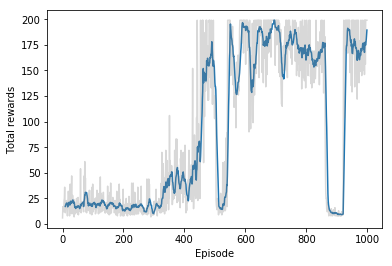

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

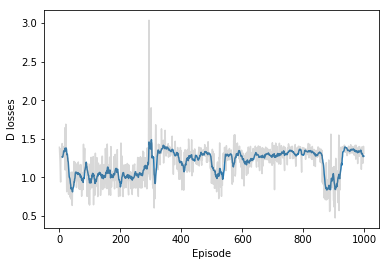

In [23]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

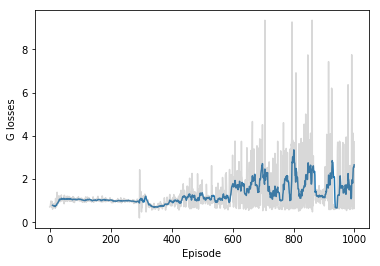

In [24]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

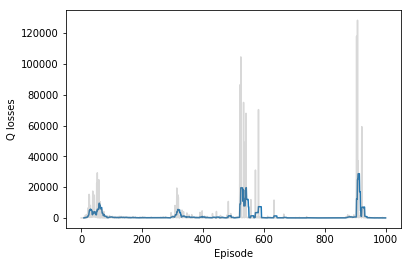

In [25]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [26]:
test_episodes = 10
test_max_steps = 10000
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [27]:
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.